# Adversarial Sample Creation

<br/>

<pre>
dataset:             imagewoof testset
image size:          128x128
adversarial attack:  BIM
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagewoof dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagewoof dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

To test our OoD detection method on adversarial OoD samples we need to create adversarial samples of the test set beforehand. After creating the adversarial version of the test set we store the adversarial testloader for our adversarial OoD detection experiment later. To create the adversarial samples we use the package [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/).

<br/>

_Sources:_
* [Imagewoof dataset](https://github.com/fastai/imagenette)
* [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torchattacks
import PIL
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
from pathlib import Path
import shutil
import random

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('torchattacks:        {}'.format(torchattacks.__version__))
print('PIL version:         {}'.format(PIL.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
torchattacks:        2.13.2
PIL version:         8.0.1
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

In [3]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagewoof')        # Base data folder
fname_string      = 'imagewoof_{}'.format(img_size)                                 # Dataset folder name
dataset_path      = base_data_folder/fname_string                                   # Dataset path
dataloader_path   = base_data_folder/(fname_string+'_resnet18')                     # Dataloader path
batch_size_test   = 1000                                                            # Batch size test set
calibset_size     = 750                                                             # Size of the calibration set

# Model
base_model_folder = Path('/Users/lehmann/research/laca3/models/imagewoof')          # Base model folder
fname_string     += '_resnet18_model'                                               # Model name
model_path        = base_model_folder/fname_string                                  # Model path
arch              = models.resnet18(pretrained=False)                               # Network architecture

# Adversarial attack
fname_string     += '_adv_bim2'                                                     # Adversarial file name
adv_path         = base_data_folder/fname_string                                    # Adversarial file path
bim_eps          = 0.1                                                              # BIM eps
bim_alpha        = 0.005                                                             # BIM alpha
bim_steps        = 20                                                               # BIM steps
# CAUTION --> make sure attack method is changed to BIM below!

## Parameters

## Function for Displaying Images

In [4]:
labels = (
    'Samoyed',
    'English foxhound',
    'Old English sheepdog',
    'Rhodesian ridgeback',
    'beagle',
    'Australian terrier',
    'golden retriever',
    'dingo',
    'Shih-Tzu',
    'Border terrier'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets, normalized=False):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        if normalized:
            img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
            img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
            img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
            img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [5]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples. When we split the dataset we use the seed value for [reproducibility](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [6]:
# Data path
test_path = dataset_path/'val'

# Test set 
orig_testset = datasets.ImageFolder(
    root=str(test_path), transform=transform_test
)
orig_testset_size = len(orig_testset)
testset_size = orig_testset_size - calibset_size

# Calibration set 
testset, calibset = torch.utils.data.random_split(
    orig_testset, [testset_size, calibset_size], generator=torch.Generator().manual_seed(seed)
)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=0
)

# Create calib dataloader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=0
)

# Check size of training set, test set and calibration set
test_size = len(testloader.dataset)
calib_size = len(calibloader.dataset)

print('testset size:  {}'.format(test_size))
print('calibset size: {}'.format(calib_size))

testset size:  3179
calibset size: 750


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


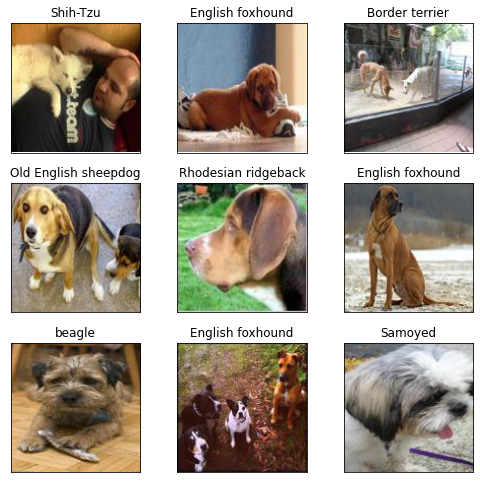

In [7]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets, True)

tensor shape: (750, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


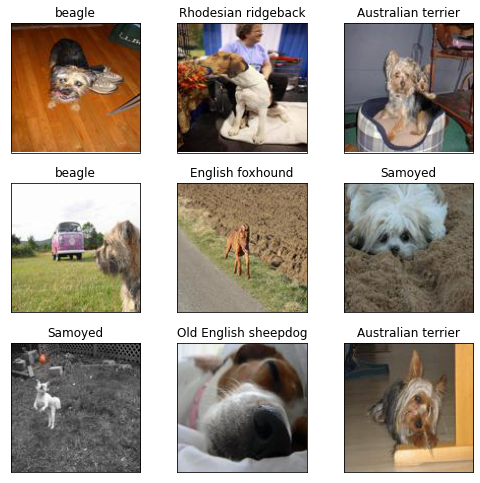

In [8]:
# Display a few calibxration images
calib_dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(calib_dataiter)

show_samples(calib_sample_data, calib_sample_targets, True)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [9]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Test Functions

In [11]:
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Testing

In [12]:
# Create Model
model = arch
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load(str(model_path)+'.pth', map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [13]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [14]:
test_acc = test_final(model, testloader, criterion); test_acc


Test set: Avg. loss: 0.001599, Accuracy: 2385/3179 (75.02%)



75.02359232463039

## Create Adversarial Samples

We will receive our adversarial samples in a tensor later. To load the tensor as a dataset we need to create a custom PyTorch dataset class.

In [15]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

For creating the adversarial samples we only use the test set and not the calibration set. Actually, we could also use the calibration set because these will be totally new samples. However, we cannot be sure that the adversarial attack is perfect. Thus, it could be that our model will still recognize some of the calibration samples. However, these samples shouldn't be used as test samples. Hence, we do not use calibration samples at all to avoid this situation.

In [16]:
# Original test set 
orig_unnorm_testset = datasets.ImageFolder(
    root=str(test_path), transform=transforms.ToTensor()
)
orig_unnorm_testset_size = len(orig_testset)
unnorm_testset_size = orig_unnorm_testset_size - calibset_size

# Test set without calibration set
unnorm_testset, _ = torch.utils.data.random_split(
    orig_unnorm_testset, [unnorm_testset_size, calibset_size], generator=torch.Generator().manual_seed(seed)
)

# Create test dataloader
unnorm_testloader = torch.utils.data.DataLoader(
    unnorm_testset, batch_size=test_size, shuffle=False, num_workers=0
)

# Check size of test set
unnorm_test_size = len(testloader.dataset)
dataset_correct = test_size == unnorm_test_size

print('dataset correct: {}'.format(dataset_correct))
print('testset size:  {}'.format(test_size))

dataset correct: True
testset size:  3179


tensor shape: (3179, 3, 128, 128)

min pixel value: 0.0
max pixel value: 1.0


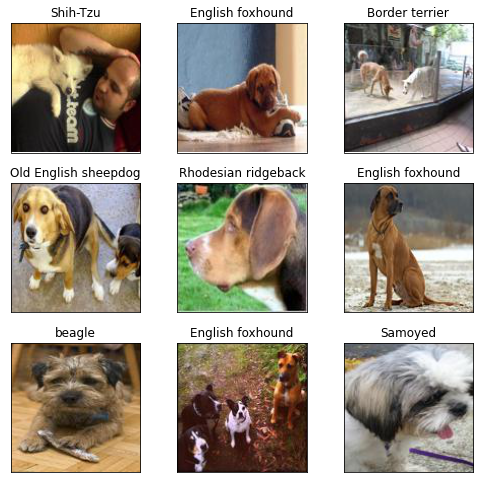

In [17]:
# Display a few test images
unnorm_test_dataiter = enumerate(unnorm_testloader)
_, (unnorm_test_batch_data, unnorm_test_batch_targets) = next(unnorm_test_dataiter)

show_samples(unnorm_test_batch_data, unnorm_test_batch_targets, False)

In [18]:
# Check if the batch contains all test images
batch_correct = len(unnorm_test_batch_data) == test_size and len(unnorm_test_batch_targets) == test_size
print('batch correct: {}'.format(batch_correct))

batch correct: True


To perform the adversarial attack we use the package [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/). __Make sure to set the correct attack here!__

In [19]:
# Adversarial sample creation
atk = torchattacks.BIM( # <--- make sure that correct attack method is set!
    model, eps=bim_eps, alpha=bim_alpha, steps=bim_steps
)  
adv_test_batch_data = atk(unnorm_test_batch_data, unnorm_test_batch_targets)

In [20]:
# Create adversarial set
advdataset = CustomTensorDataset(
    tensors=(adv_test_batch_data, unnorm_test_batch_targets), 
    transform=transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std'])
)

# Create adversarial dataloader
advloader = torch.utils.data.DataLoader(
    advdataset, batch_size=batch_size_test, shuffle=False, num_workers=0
)

# Check size of adversarial set
adv_test_size = len(advloader.dataset)
dataset_correct = test_size == adv_test_size

print('dataset correct: {}'.format(dataset_correct))
print('testset size:  {}'.format(adv_test_size))

dataset correct: True
testset size:  3179


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


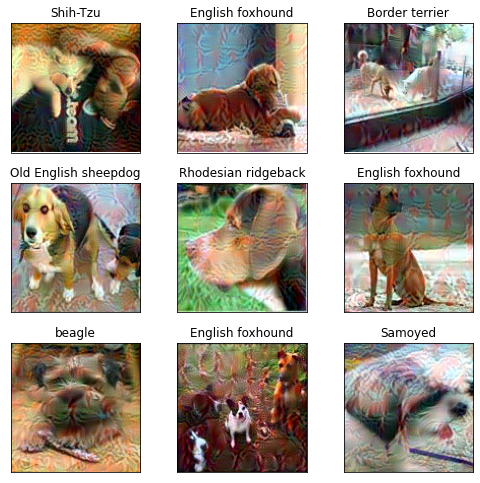

In [21]:
# Display a few adversarial images
adv_dataiter = enumerate(advloader)
_, (adv_sample_data, adv_sample_targets) = next(adv_dataiter)

show_samples(adv_sample_data, adv_sample_targets, True)

In [22]:
# Test created adversarial set against our model
adv_acc = test_final(model, advloader, criterion)
print('Test accuracy:        {}'.format(test_acc))
print('Adversarial accuracy: {}'.format(adv_acc))


Test set: Avg. loss: 0.019267, Accuracy: 76/3179 (2.39%)

Test accuracy:        75.02359232463039
Adversarial accuracy: 2.390688895879207


## Store Adversarial Images as Pth File

To store our adversarial test set for later we simply save the test dataloader. Then, we can use it later to test our method on these adversarial test samples as adversarial OoD samples.

In [23]:
# Remove old pth file and create new one
!rm -f {str(adv_path)+'.pth'}
torch.save(advloader, str(adv_path)+'.pth')

In [24]:
loaded_advloader = torch.load(str(adv_path)+'.pth')

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


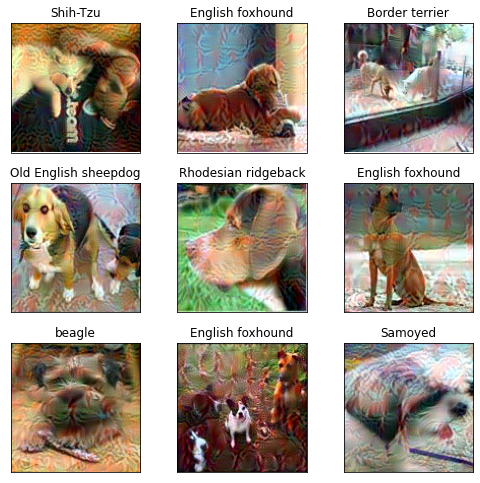

In [25]:
# Display a few adversarial images
loaded_adv_dataiter = enumerate(loaded_advloader)
_, (loaded_adv_sample_data, loaded_adv_sample_targets) = next(loaded_adv_dataiter)

show_samples(loaded_adv_sample_data, loaded_adv_sample_targets, True)

In [26]:
# Test created adversarial set against our model
loaded_adv_acc = test_final(model, loaded_advloader, criterion)
print('Test accuracy:        {}'.format(test_acc))
print('Adversarial accuracy: {}'.format(adv_acc))
print('Correctly loaded:     {}'.format(adv_acc == loaded_adv_acc))


Test set: Avg. loss: 0.019267, Accuracy: 76/3179 (2.39%)

Test accuracy:        75.02359232463039
Adversarial accuracy: 2.390688895879207
Correctly loaded:     True
